In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import time
# from scipy.stats import gaussian_kde
# import scipy.stats as stats

In [2]:
from dataset import Step5_DataSet
from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset

In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
import kgml_lib
Z_norm_reverse = kgml_lib.Z_norm_reverse
Z_norm_with_scaler = kgml_lib.Z_norm_with_scaler

In [5]:
root_dir = 'E:/PyKGML/deposit_code_v2/'
data_path = root_dir +  'processed_data/'
output_path = root_dir + 'test_results/'

#input_data = 'recotest_data_scaled_v4_100sample.sav'
#sample_index_file = "flux_split_year_v1.sav"

pretrained_model = "recotest_v11_exp4.sav_step4"
output_model = "recotest_v11_exp4_sample.sav_step5"
synthetic_data = "sys_data10.sav"

dataset = Step5_DataSet(data_path, output_path)
dataset.load_scaler_data('recotest_data_scaled_v4_scalers.sav')
dataset.load_fluxtower_inputs_data('fluxtower_inputs_noscale_v2.sav')
dataset.load_fluxtower_observe_data('fluxtower_observe_noscale_v2.sav')

dataset.prepare_data('flux_split_year_v1.sav')

torch.Size([3285]) torch.Size([1, 3285, 19])
torch.Size([1825]) torch.Size([1, 1825, 19])
torch.Size([2555]) torch.Size([1, 2555, 19])
torch.Size([2555]) torch.Size([1, 2555, 19])
torch.Size([5110]) torch.Size([1, 5110, 19])
torch.Size([3650]) torch.Size([1, 3650, 19])
torch.Size([6935]) torch.Size([1, 6935, 19])
torch.Size([6935]) torch.Size([1, 6935, 19])
torch.Size([6935]) torch.Size([1, 6935, 19])
torch.Size([4015]) torch.Size([1, 4015, 19])
torch.Size([1460]) torch.Size([1, 1460, 19])


In [6]:
# Calculate Y1 and Y2  mean and std value
y1 = dataset.Y_NEE_obs
y2 = dataset.Y_Reco_obs

y1_NEE = torch.cat(y1).cpu().numpy()
y2_Reco = torch.cat(y2).cpu().numpy()

y1_NEE = y1_NEE.astype(np.float32)
y2_Reco = y2_Reco.astype(np.float32)

y1_NEE_scaler = [np.mean(y1_NEE), np.std(y1_NEE)]
y2_Reco_scaler = [np.mean(y2_Reco), np.std(y2_Reco)]

In [7]:
# Split train and test dataset
# 11 sites, choose each site's last two years for test

x = dataset.X_sites
y1 = dataset.Y_NEE_obs
y2 = dataset.Y_Reco_obs

test_days = 365*2 # 2 years 

train_X_list = []
test_X_list = []
train_Y_list = []
test_Y_list = []

for i in range(len(x)):
    train_x = x[i][:,:-test_days,:]
    test_x = x[i][:,-test_days:,:]
    train_X_list.append(train_x)
    test_X_list.append(test_x)

    # _y1 = y1[i].unsqueeze(1)
    _y1 = Z_norm_with_scaler(y1[i].type(torch.float32), y1_NEE_scaler).unsqueeze(1)
    # _y2 = y2[i].unsqueeze(1)
    _y2 = Z_norm_with_scaler(y2[i].type(torch.float32), y2_Reco_scaler).unsqueeze(1)
    _y = torch.cat((_y1,_y2), dim=1)

    train_y = _y[:-test_days,:]
    test_y  = _y[-test_days:,:]
    train_Y_list.append(train_y)
    test_Y_list.append(test_y)

X_train = torch.cat(train_X_list, dim=1)
X_test  = torch.cat(test_X_list,  dim=1)

Y_train = torch.cat(train_Y_list, dim=0)
Y_train = Y_train.unsqueeze(0) 
Y_test  = torch.cat(test_Y_list,  dim=0)
Y_test = Y_test.unsqueeze(0)

In [8]:
Y_train.shape, X_train.shape

(torch.Size([1, 37230, 2]), torch.Size([1, 37230, 19]))

In [9]:
# Set parameters for create a Module
num_input_features = 19
num_output_features = 2

input_dim = num_input_features
hidden_dim = 128
num_layers = 3
output_dim = num_output_features
dropout=0.2

In [10]:
# Choose one of the models below:
#model = LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)
# model = GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)

# model = EnhancedGRUModel(input_dim, hidden_dim, num_layers, output_dim)

model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [11]:
# Create Pytorch dataloader
sequence_length = 365  # Use 365 consecutive days as a sample

# Create Dataset objects for training and testing.
train_dataset = SequenceDataset(X_train, Y_train, sequence_length)
test_dataset = SequenceDataset(X_test, Y_test, sequence_length)

# Create DataLoaders.
batch_size = 64
model.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [12]:
learning_rate = 0.001
step_size = 40
max_epoch = 200
gamma = 0.8
loss_function = nn.L1Loss() # nn.MSELoss()

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/200 | LR: 0.001000, Train Loss: 0.6763, Test Loss: 0.5828
Epoch 2/200 | LR: 0.001000, Train Loss: 0.5749, Test Loss: 0.5063
Epoch 3/200 | LR: 0.001000, Train Loss: 0.5127, Test Loss: 0.4540
Epoch 4/200 | LR: 0.001000, Train Loss: 0.4473, Test Loss: 0.4088
Epoch 5/200 | LR: 0.001000, Train Loss: 0.3932, Test Loss: 0.3809
Epoch 6/200 | LR: 0.001000, Train Loss: 0.3595, Test Loss: 0.3482
Epoch 7/200 | LR: 0.001000, Train Loss: 0.3230, Test Loss: 0.3142
Epoch 8/200 | LR: 0.001000, Train Loss: 0.3016, Test Loss: 0.3213
Epoch 9/200 | LR: 0.001000, Train Loss: 0.2962, Test Loss: 0.3099
Epoch 10/200 | LR: 0.001000, Train Loss: 0.2772, Test Loss: 0.2966
Epoch 11/200 | LR: 0.001000, Train Loss: 0.2633, Test Loss: 0.2934
Epoch 12/200 | LR: 0.001000, Train Loss: 0.2609, Test Loss: 0.2891
Epoch 13/200 | LR: 0.001000, Train Loss: 0.2560, Test Loss: 0.2853
Epoch 14/200 | LR: 0.001000, Train Loss: 0.2476, Test Loss: 0.2835
Epoch 15/200 | LR: 0.001000, Train Loss: 0.2449, Test Loss: 0.2745
Epoc

In [13]:
model.test()

Test Loss: 0.1814


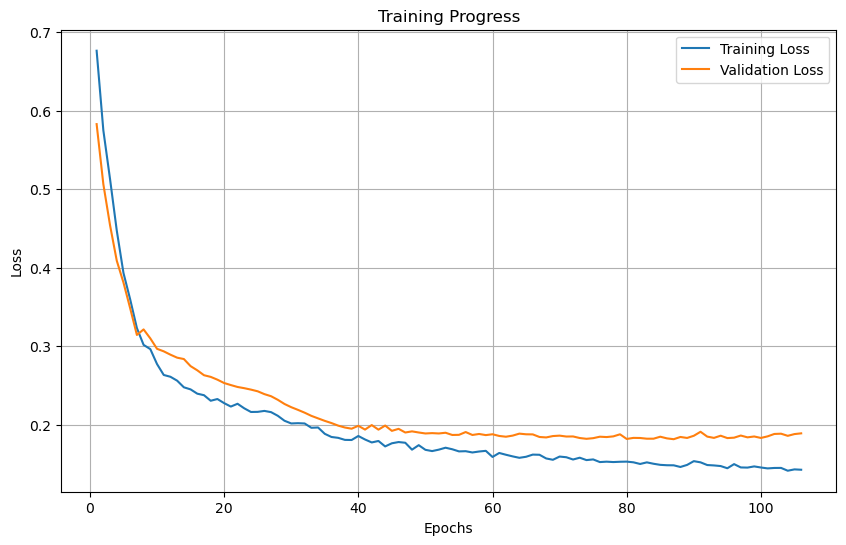

In [14]:
model.plot_training_curves()

In [15]:
y_scaler = [y1_NEE_scaler,y2_Reco_scaler]
output_feature_name = ['NEE','RECO']
model.get_R2_score(y_scaler, output_feature_name)

Feature NEE R2 Score is: 0.9269153658708387
Feature RECO R2 Score is: 0.8811219595747097


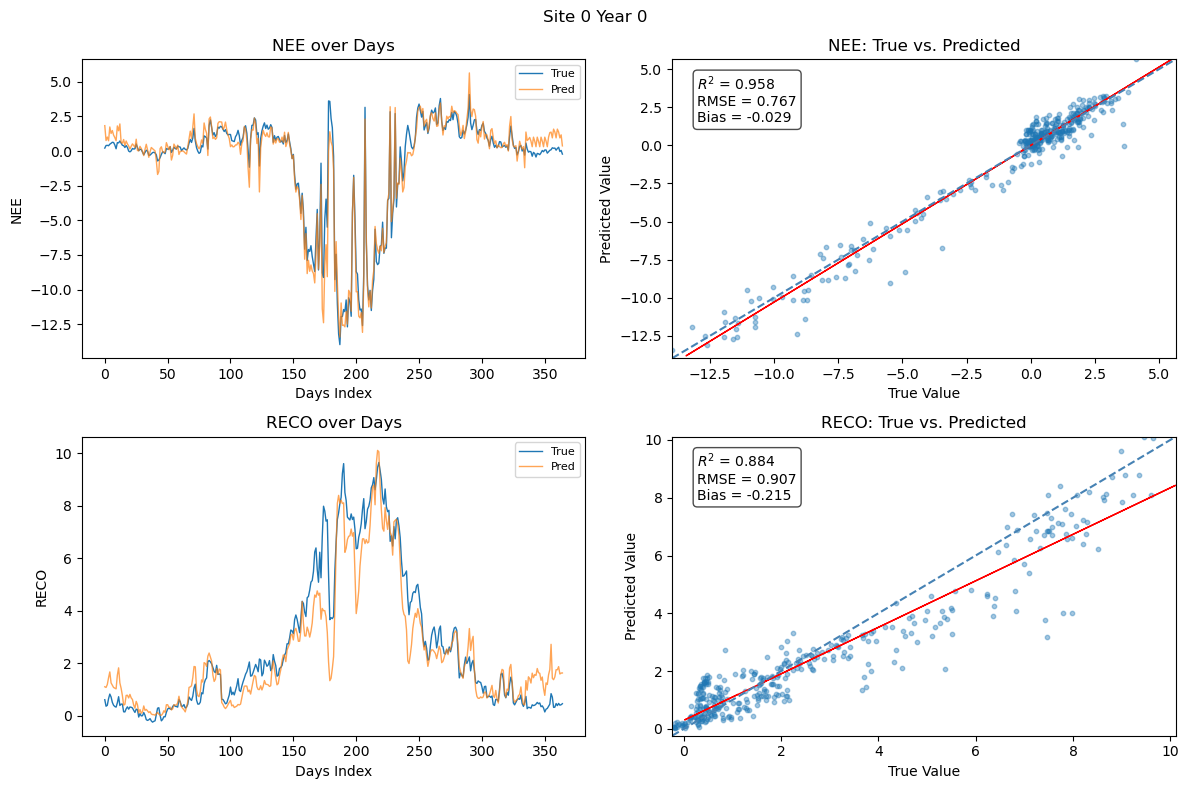

In [16]:
model.Vis_prediction_result(y_scaler, output_feature_name, site=0, year=0)